# IoD CAPSTONE PROJECT
## NOVEL SENTIMENT LABELLING METHODS
### By Jack Sticklen

### Core problem to be addressed
When training machine learning models, it is valuable to have a training dataset, where the value we wish to predict is part of the data (known commonly as labelled data). It allows for the use of a broader range of techniques, and allows for easy checking of various performance metrics, according to the needs of the data scientist. However, data scientists often find themselves without this convenience, and one of the most common areas where this problem arises is in sentiment analysis.
<br><br>
When gathering a corpus of different bodies of documents to analyse for a specific application, there is rarely reliable accompanying sentiment data. Now, aside from the time-consuming brute force manual labelling of part of the data, data scientists have come up some techniques for obtaining a training dataset. Commonly they will train their models on large pre-labelled datasets from the literature; this approach can be useful, but these datasets (such as the IMDB data set) are often not contextually relevant to the application, so the models trained on them can often underperform. Another approach is to take a lexicon of words with positive or negative sentiment polarity, and process each document through this dictionary to achieve a final sentiment score. This can work, but is usually out-performed by machine learning methods.
<br><br>
In my project, I've decided to adapt a novel approach to sentiment labelling from the literature and apply it to a collection of tweets. In this paper by Ramteke et. al., they have come up with a unique way to label a corpus of unlabelled tweets that works particularly well on twitter data in a competitive or election context. They generate a training set via a combination of two methods: First, from their dataset of tweets (the subject of which is tweets during the 2016 US election), they label tweets according to common partisan hashtags, under the assumption that a user using that hashtag has a positive sentiment for the party it's associated with. For example, they assumed all tweets with the hashtag #MakeAmericaGreatAgain were expressing positive sentiment for Trump. For the second method, they used a sentiment polarity lexicon called VADER to assign positive, negative, and neutral scores for each tweet. Rather than take the highest score as the final sentiment, they only included in their training set the tweets where the sentiment score was unambiguously positive or negative (>=0.8 and <=-0.8 respectively). With this as their training set, they then went on to train their model.
<br><br>
However, in their paper, they did not verify the accuracy of their labelling technique on manually labelled data. Thus, in my capstone, I have applied a modified version of their technique on an open-source, manually labelled twitter dataset in order to verify the technique's actual effectiveness. For my dataset, I've used a collection of tweets centred around the GOP debates, found here: https://www.kaggle.com/datasets/crowdflower/first-gop-debate-twitter-sentiment?resource=download. 

In [151]:
# Import libraries

import pandas as pd
import numpy as np
import scipy
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import vaderSentiment as VADER
import nltk
import spacy
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
import random
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [152]:
# Load the data
datafile = 'archive/Sentiment.csv'
debate = pd.read_csv(datafile)
debate.head()

,id,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,candidate_gold,...,relevant_yn_gold,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,1,No candidate mentioned,1.0,yes,1.0,Neutral,0.6578,None of the above,1.0000,NaN,...,NaN,5,NaN,NaN,RT @NancyLeeGrahn: How did everyone feel about...,NaN,2015-08-07 09:54:46 -0700,629697200650592256,NaN,Quito
1,2,Scott Walker,1.0,yes,1.0,Positive,0.6333,None of the above,1.0000,NaN,...,NaN,26,NaN,NaN,RT @ScottWalker: Didn't catch the full #GOPdeb...,NaN,2015-08-07 09:54:46 -0700,629697199560069120,NaN,NaN
2,3,No candidate mentioned,1.0,yes,1.0,Neutral,0.6629,None of the above,0.6629,NaN,...,NaN,27,NaN,NaN,RT @TJMShow: No mention of Tamir Rice and the ...,NaN,2015-08-07 09:54:46 -0700,629697199312482304,NaN,NaN
3,4,No candidate mentioned,1.0,yes,1.0,Positive,1.0000,None of the above,0.7039,NaN,...,NaN,138,NaN,NaN,RT @RobGeorge: That Carly Fiorina is trending ...,NaN,2015-08-07 09:54:45 -0700,629697197118861312,Texas,Central Time (US & Canada)
4,5,Donald Trump,1.0,yes,1.0,Positive,0.7045,None of the above,1.0000,NaN,...,NaN,156,NaN,NaN,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,NaN,2015-08-07 09:54:45 -0700,629697196967903232,NaN,Arizona


In [153]:
# We are only interested in: candidate, sentiment, sentiment_confidence, 
# and text. Remove all other columns
debate.drop(['id','candidate_confidence', 'relevant_yn', 
    'relevant_yn_confidence', 'subject_matter', 'subject_matter_confidence', 
    'candidate_gold', 'name', 'relevant_yn_gold', 'retweet_count',
    'sentiment_gold', 'subject_matter_gold', 'tweet_coord', 'tweet_created',
    'tweet_id', 'tweet_location', 'user_timezone'], axis=1, inplace=True)

debate.sample(5)

,candidate,sentiment,sentiment_confidence,text
5729,No candidate mentioned,Negative,0.6932,17 Funniest Tweets on #GOPDebate Failing to Ev...
11324,Donald Trump,Negative,0.6611,RT @ericstonestreet: Trump has Cam hands. #GOP...
2585,Mike Huckabee,Neutral,1.0000,"""the military's favorite song is Break Stuff b..."
11654,Donald Trump,Negative,0.6548,RT @RWSurferGirl: Ask Trump a legitimate quest...
1532,Donald Trump,Negative,0.6329,@lyndonjackmon Dearheart #BoyAboutTown is neve...


In [154]:
# Check for null values and column datatypes
debate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13871 entries, 0 to 13870
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   candidate             13775 non-null  object 
 1   sentiment             13871 non-null  object 
 2   sentiment_confidence  13871 non-null  float64
 3   text                  13871 non-null  object 
dtypes: float64(1), object(3)
memory usage: 433.6+ KB


In [155]:
# Some null values in candidate column. Small number relative to dataset,
# so we will just remove those rows.
debate = debate.dropna()
debate.shape

(13775, 4)

In [156]:
# Check how many neutral sentiments were assigned
debate.sentiment.value_counts()

Negative    8447
Neutral     3106
Positive    2222
Name: sentiment, dtype: int64

In [157]:
# For our purposes (positive/negative sentiment labelling), 
# manually-assigned neutral values are not useful. Drop them
debate_polarised = debate.loc[debate['sentiment'] != 'Neutral']

# Verify
debate_polarised.sentiment.value_counts()

Negative    8447
Positive    2222
Name: sentiment, dtype: int64

In [158]:
# Transform sentiment column into binary data for classification tasks
debate_polarised['sentiment'] = debate_polarised['sentiment'] == 'Positive'
# Verify
debate_polarised.sentiment.value_counts()

C:\Users\jacks\AppData\Local\Temp\ipykernel_1692\1240681586.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  debate_polarised['sentiment'] = debate_polarised['sentiment'] == 'Positive'


False    8447
True     2222
Name: sentiment, dtype: int64

In [159]:
# Check candidates
debate_polarised.candidate.value_counts()

No candidate mentioned    5404
Donald Trump              2367
Jeb Bush                   633
Ted Cruz                   511
Ben Carson                 350
Mike Huckabee              310
Chris Christie             251
Marco Rubio                224
Scott Walker               221
Rand Paul                  203
John Kasich                195
Name: candidate, dtype: int64

In [160]:
# Need to generate dictionary of hashtags:frequency from data. 
# Create formula for application - extracting hashtags from text
def extract_hashtag(text):
    # initialise empty list
    hash_list = []
    
    # split text into indidual words
    for word in text.split():
        # check for hashtags and add to list
        if word[0] == '#':
            hash_list.append(word)
    return hash_list


In [161]:
# Apply formula to each text column and store in dictionary
# initialise dictionary
hash_dict = {}

# loop over values in dataframe
for tweet in debate_polarised.text:
    # extract hashtags
    hash_list = extract_hashtag(tweet)

    # add each value to dict, upping frequency count for those already there
    for hash in hash_list:
        # if statement to ignore generic #GOPDebate variants
        if hash[1:4] != 'GOP' and hash[1:4] != 'gop' and hash[1:4] != 'Gop':
            # if statement to discern between new and already present hashtags
            if hash in hash_dict.keys():
                hash_dict[hash] += 1
            else:
                hash_dict[hash] = 1

# Retrieve top 30 hashtags from dict
from operator import itemgetter
res = dict(sorted(hash_dict.items(), key = itemgetter(1), reverse = True)[:30])
print(res)


{'#G…': 146, '#tcot': 141, '#Trump': 125, '#TedCruz': 121, '#…': 113, '#FoxNews': 85, '#DonaldTrump': 84, '#KKKorGOP': 76, '#BlackLivesMatter': 68, '#Trump2016': 60, '#DemocraticDebates': 59, '#FoxDebate': 52, '#MegynKelly': 37, '#DebateWithBernie': 36, '#p2': 36, '#GO…': 32, '#ccot': 31, '#morningjoe': 30, '#CantTrustABush': 30, '#FOXNEWSDEBATE': 28, '#CruzCrew': 25, '#RandPaul': 25, '#TedCruz2016': 25, '#KellyFile': 24, '#Walker16': 23, '#Fiorina': 23, '#TCOT': 23, '#SURREAL': 23, '#Kasich': 21, '#BenCarson': 21}


[]

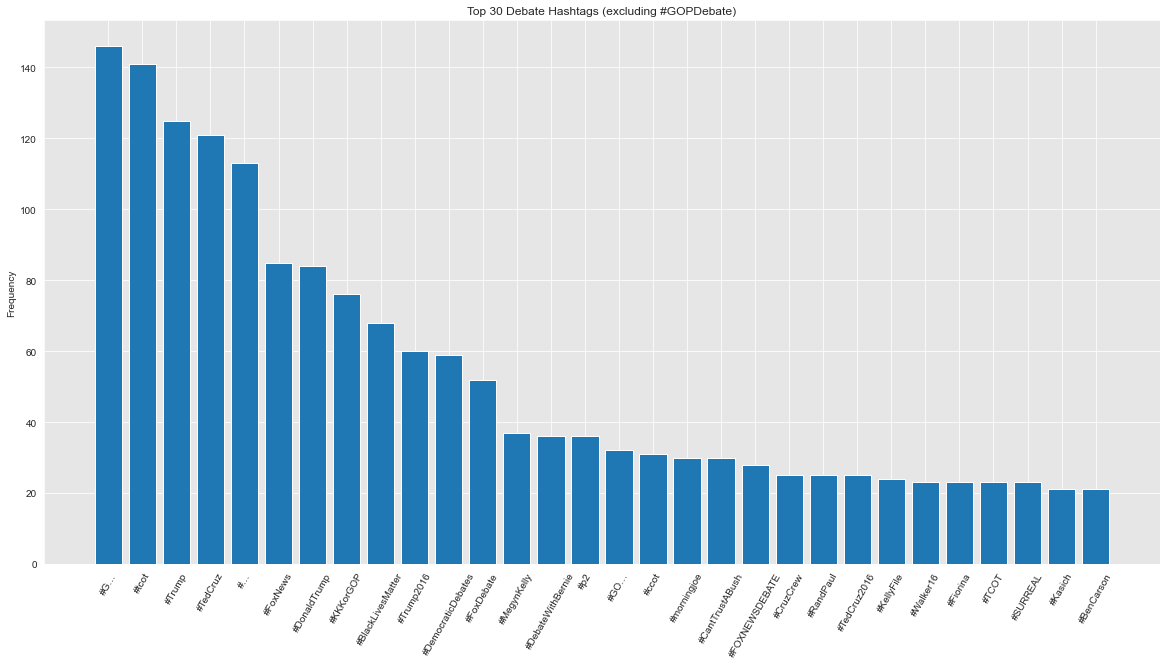

In [229]:
# Plot the top hashtags
plt.figure(figsize=(20, 10))
plt.bar(range(len(res)), list(res.values()))
plt.xticks(range(len(res)), list(res.keys()), rotation=60)
plt.title('Top 30 Debate Hashtags (excluding #GOPDebate)')
plt.ylabel('Frequency')
plt.plot()

From the above list of hashtags, we will assume the following from the political context of the USA in 2016:
- All tweets with official candidate hashtags (eg. #Trump2016) are positively sentimental towards the candidate in question. Excludes hashtags with just the candidate name, as could be just mentioning them.
- The following hashtags are to be considered negatively sentimental towards the subject: #KKKorGOP, #BlackLivesMatter, #CantTrustABush, #DebateWithBernie.
<br><br>
Add synthetic sentiment labels to rows with the relevant hashtags

In [162]:
# Add column to dataframe with hashtags
debate_polarised['hashtags'] = debate_polarised.text.apply(extract_hashtag)

C:\Users\jacks\AppData\Local\Temp\ipykernel_1692\1079068216.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  debate_polarised['hashtags'] = debate_polarised.text.apply(extract_hashtag)


In [163]:
#Lists of positive and negative hashtags
positive_hashtags = ['#Trump2016', 
                    '#CruzCrew', '#TedCruz2016', '#Walker16']
negative_hashtags = ['#KKKorGOP', '#BlackLivesMatter', '#CantTrustABush', 
                    '#DebateWithBernie']

In [164]:
# Create function to assign sentiment value
def hashtag_sentiment(hashtags):
    # Initialise value
    flag = np.nan
    # Checking for sentiment hashtag first 
    for val in hashtags:
        # Negative considered to override positive
        if flag != 0:
            # Loop over negative hashtags, flag if present
            if val in negative_hashtags:
                flag = 0
            # Loop over positive hashtags, flag if present
            elif val in positive_hashtags:
                flag = 1
    return flag

In [165]:
# Apply function to dataframe, create new column
debate_polarised['synthetic_sentiment'] = debate_polarised.hashtags.apply(hashtag_sentiment)
debate_polarised.synthetic_sentiment.value_counts()

C:\Users\jacks\AppData\Local\Temp\ipykernel_1692\3996736923.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  debate_polarised['synthetic_sentiment'] = debate_polarised.hashtags.apply(hashtag_sentiment)


0.0    208
1.0    130
Name: synthetic_sentiment, dtype: int64

In [166]:
# Second step - using VADER to generate polarity scores
# Create function to clean tweet into basic sentence
def tweet_cleaner(tweet):
    tweet = re.sub("@[A-Za-z0-9]+","",tweet) #Remove @ sign
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) #Remove http links
    tweet = tweet.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    tweet = re.sub("RT\s", "", tweet) #Remove RT
    tweet = tweet.replace(".","") # remove full stop
    tweet = re.sub(r'(\s\s+|\n\n+)', r'\1', tweet) # reduce multiple spaces and newlines to only one
    text = re.sub(r'"', '', tweet) # remove double quotes
    return tweet

# import analyser
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Create function to apply analyser and generate self-chosen sentiment score
def vader_sentiment_score(tweet, proba=False, threshold=0.8):
    # Clean tweet
    tweet = tweet_cleaner(tweet)

    # Create sentiment analyser object
    analyser = SentimentIntensityAnalyzer()

    # Apply analyser to tweet
    sentiment_dict = analyser.polarity_scores(tweet)

    # Differentiate between whether we want proba values or just threshold results
    if proba:
        # Generate proba score equivalents from polarity scores
        if (sentiment_dict['pos']) == 0 and (sentiment_dict['neg']) == 0:
            pos = 0.5
            neg = 0.5
        else:
            pos = sentiment_dict['pos']/(sentiment_dict['pos'] + sentiment_dict['neg'])
            neg = sentiment_dict['neg']/(sentiment_dict['pos'] + sentiment_dict['neg'])
        flag = np.array([neg, pos])

       
    else:
        # Generate sentiment score
        # initialise value as NaN
        flag = np.nan
        # Check for extreme positive or extreme negative polarity
        if sentiment_dict['compound'] >= threshold:
            flag = 1
        elif sentiment_dict['compound'] <= -threshold:
            flag = 0
    # return final value    
    return flag


In [167]:
# Apply function to dataframe tweets
polarity_sentiment = debate_polarised.text.apply(vader_sentiment_score, threshold=0.7)


In [168]:
# Merge new values with synthetic_sentiment column in df
# Begin by creating a new array with maximal non-null values
# initialise array
synthetics = np.empty(len(debate_polarised.synthetic_sentiment))

# Use for loop to iterate over series
for i in range(len(debate_polarised.synthetic_sentiment)):
    # Check if hashtag sentiment assignment has been performed on element
    if debate_polarised.synthetic_sentiment.iloc[i] == 0 or debate_polarised.synthetic_sentiment.iloc[i] == 1:
        # assign hashtag sentiment first as priority
        synthetics[i] = debate_polarised.synthetic_sentiment.iloc[i]
    else:
        # if no hashtag sentiment, assign the polarity sentiment (will be NaN if none)
        synthetics[i] = polarity_sentiment.iloc[i]

# Replace original column with array
debate_polarised['synthetic_sentiment'] = synthetics

# Verify
debate_polarised.synthetic_sentiment.value_counts()

C:\Users\jacks\AppData\Local\Temp\ipykernel_1692\246143360.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  debate_polarised['synthetic_sentiment'] = synthetics


1.0    830
0.0    737
Name: synthetic_sentiment, dtype: int64

In [169]:
# We have our training data. Now it's time to apply machine learning
# First step is to pre-process the tweet document data.
# First, need to load spacy
nlp = spacy.load('en_core_web_sm')

# Create a function to deal with processing requirements
def tweet_preprocess(tweet):
    """This function does three things. 
    First, it removes or normalises common non-word tweet text.
    Second, it removes stop words.
    Third, it lemmatises the text"""
    # clean text with previously defined function
    text = tweet_cleaner(tweet)

    # tokenise with spacy
    doc = nlp(text)

    # remove punctuation
    text_list = [token.text for token in doc if not token.is_punct]
    text = ' '.join(text_list)
    doc = nlp(text)    

    # remove stopwords
    all_stopwords = nlp.Defaults.stop_words
    clean_token = []
    for token in doc:
        if not (token.is_stop):
            clean_token.append(token.text)
    clean_token = ' '.join(clean_token)
    doc = nlp(clean_token)
    
    # lemmatize
    text = [word.lemma_ for word in doc] 
    text = ' '.join(text)

    return text




In [170]:
# Apply preprocessing to tweet data
A = debate_polarised.text.apply(tweet_preprocess)
debate_polarised['processed_text'] = A

C:\Users\jacks\AppData\Local\Temp\ipykernel_1692\2466394286.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  debate_polarised['processed_text'] = A


In [171]:
# Separate out the training targets from the rest of the data
X_train_1 = debate_polarised.dropna()['processed_text']
y_train_1 = debate_polarised.dropna()['synthetic_sentiment']

# Verify length
X_train_1.shape

(1567,)

In [172]:
# Apply TF-IDF vectorizer to get weighted word vector count for each tweet
# Load vectorizer
vectorizer = TfidfVectorizer()
# Train the vectorizer on whole corpus
vectorizer.fit(debate_polarised['processed_text'])
# Transform training data
X_train_1 = vectorizer.transform(X_train_1)

In [173]:
# Generate testing data - in this case we will use 20% of the original set
# First, eliminate datapoints used in the training
debate_polarised_filtered = debate_polarised.loc[(debate_polarised['synthetic_sentiment'] != 1) & (debate_polarised['synthetic_sentiment'] != 0)]

# Verify shape
debate_polarised_filtered.shape

(9102, 7)

In [174]:
# Extract random test data
n = round(0.2 * len(debate_polarised_filtered))
TEST = debate_polarised_filtered.sample(n)
X_test_raw = TEST['text']
y_test = TEST['sentiment']


In [175]:
# Process test features
X_test = vectorizer.transform(X_test_raw.apply(tweet_preprocess))

In [176]:
# We have our test and training data, time to put them through a model
# First, will create a function that applies the model and generates valuable metrics

def model_metrics(rowname, model, X_train, y_train, X_test=X_test, y_test=y_test):
    '''
    Inputs are as follows:
    Rowname: string that designates the identity of the results
    model: machine learning classifier object, eg. sklearn.svm.SVC()
    X_train: training features
    X_test: testing features
    y_train: training targets
    y_test: testing targets
    '''
    # First, train the classifier
    model.fit(X_train, y_train)

    # Generate prediction and proba values
    y_pred = model.predict(X_test)
    probs = model.predict_proba(X_test)
    # Assign metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, probs[:,1])
    fpr, tpr, _ = roc_curve(y_test, probs[:,1])

    # Place values in list
    metrics = {
        'rowname':rowname, 'accuracy':accuracy, 'precision':precision, 
        'recall':recall, 'roc_auc':roc_auc, 'fpr':fpr, 'tpr':tpr
        }

    # Return list
    return metrics

In [177]:
# Also create formula to plot ROC AUC curve

def roc_auc_plot(fpr, tpr):
    sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

    plt.figure(figsize=(10, 8))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

In [178]:
# Use function with two classifiers: SVC and Naive Bayes
# Define classifiers
svc = SVC(kernel='linear', probability=True)
mnb = MultinomialNB()
rfc = RandomForestClassifier()
# Apply in function
Novelmethod_SVC_metrics = model_metrics('Novelmethod_SVC_metrics', svc, X_train_1, y_train_1)
Novelmethod_NB_metrics = model_metrics('Novelmethod_NB_metrics', mnb, X_train_1, y_train_1)
Novelmethod_RF_metrics = model_metrics('Novelmethod_RF_metrics', rfc, X_train_1, y_train_1)

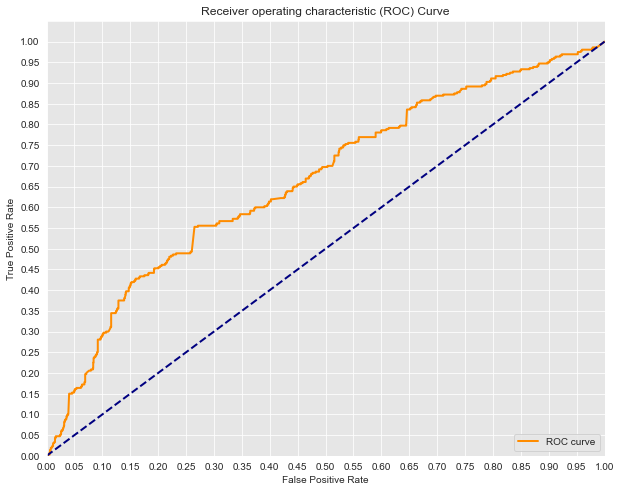

{'rowname': 'Novelmethod_SVC_metrics',
 'accuracy': 0.5225274725274726,
 'precision': 0.25738798856053385,
 'recall': 0.75,
 'roc_auc': 0.6639345509893455}

In [179]:
# Check results - SVC
roc_auc_plot(Novelmethod_SVC_metrics['fpr'], Novelmethod_SVC_metrics['tpr'])
{k:v for k,v in Novelmethod_SVC_metrics.items() if k not in ['fpr', 'tpr']}

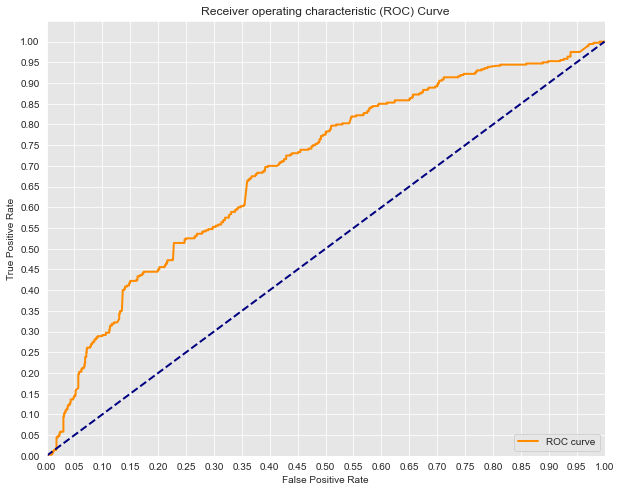

{'rowname': 'Novelmethod_NB_metrics',
 'accuracy': 0.4714285714285714,
 'precision': 0.2532786885245902,
 'recall': 0.8583333333333333,
 'roc_auc': 0.6934646118721461}

In [180]:
# Check results - NB
roc_auc_plot(Novelmethod_NB_metrics['fpr'], Novelmethod_NB_metrics['tpr'])
{k:v for k,v in Novelmethod_NB_metrics.items() if k not in ['fpr', 'tpr']}

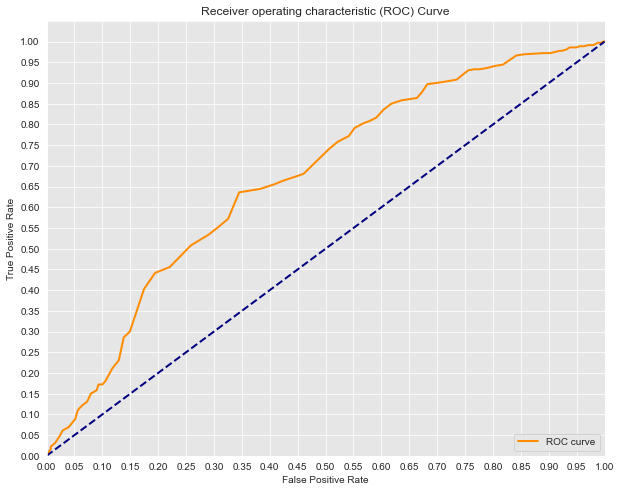

{'rowname': 'Novelmethod_RF_metrics',
 'accuracy': 0.4747252747252747,
 'precision': 0.2533112582781457,
 'recall': 0.85,
 'roc_auc': 0.6712357305936073}

In [181]:
# Check results - RF
roc_auc_plot(Novelmethod_RF_metrics['fpr'], Novelmethod_RF_metrics['tpr'])
{k:v for k,v in Novelmethod_RF_metrics.items() if k not in ['fpr', 'tpr']}

In [182]:
# Add data to a results dataframe
results = pd.DataFrame([Novelmethod_SVC_metrics, Novelmethod_NB_metrics, Novelmethod_RF_metrics]) 

results

,rowname,accuracy,precision,recall,roc_auc,fpr,tpr
0,Novelmethod_SVC_metrics,0.522527,0.257388,0.750000,0.663935,"[0.0, 0.0006849315068493151, 0.001369863013698...","[0.0, 0.0, 0.0, 0.002777777777777778, 0.002777..."
1,Novelmethod_NB_metrics,0.471429,0.253279,0.858333,0.693465,"[0.0, 0.0006849315068493151, 0.000684931506849...","[0.0, 0.0, 0.002777777777777778, 0.00277777777..."
2,Novelmethod_RF_metrics,0.474725,0.253311,0.850000,0.671236,"[0.0, 0.0, 0.0006849315068493151, 0.0027397260...","[0.0, 0.002777777777777778, 0.0027777777777777..."


## Initial Results Discussion
From the results above, one thing is clear: Various models, trained with the novel method, produce poor accuracy (ranging between 0.43 to 0.51) and poor ROC curves (maximum of 0.73 Area Under Curve, where 0.5 is considered as good as 'random guessing'). Recall is high in all models, suggesting that the training set heavily overselects for positive sentiment, misidentifying a lot of negative tweets as positively sentimental. Perhaps related to hashtag use or undetected sarcasm.
<br><br>
Next we will compare these results to more standard methods:
1. Training the model on other pre-labelled data
2. Labelling sentiment purely off VADER score

In [183]:
# Testing other methods to compare performance.
# First up: Train model on out-of-context pre-labelled data from UCI Machine Learning Repository
# Load combined Sentiment Labelled Sentences Data Set
# https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences

reviews = pd.read_csv('data/cells_labelled.csv')
reviews


,Unnamed: 0,text,sentiment
0,0,Wow... Loved this place.,1
1,1,Crust is not good.,0
2,2,Not tasty and the texture was just nasty.,0
3,3,Stopped by during the late May bank holiday of...,1
4,4,The selection on the menu was great and so wer...,1
...,...,...,...
2743,995,The screen does get smudged easily because it ...,0
2744,996,What a piece of junk.. I lose more calls on th...,0
2745,997,Item Does Not Match Picture.,0
2746,998,The only thing that disappoint me is the infra...,0


In [184]:
# Prune unnamed column
reviews.drop('Unnamed: 0', axis=1, inplace=True)

# Split into testing and training datasets
X_train_2, y_train_2 = reviews['text'], reviews['sentiment']

In [185]:
# Apply preprocessing and train and fit vectorizer
X_train_2 = vectorizer.fit_transform(X_train_2.apply(tweet_preprocess))

In [186]:
# Transform test features once more
X_test_2 = vectorizer.transform(X_test_raw.apply(tweet_preprocess))

In [187]:
# Run fit data
# Apply in function
pretrain_SVC_metrics = model_metrics('pretrain_SVC_metrics', svc, X_train_2, y_train_2, X_test_2)
pretrain_NB_metrics = model_metrics('pretrain_NB_metrics', mnb, X_train_2, y_train_2, X_test_2)
pretrain_RF_metrics = model_metrics('pretrain_RF_metrics', rfc, X_train_2, y_train_2, X_test_2)

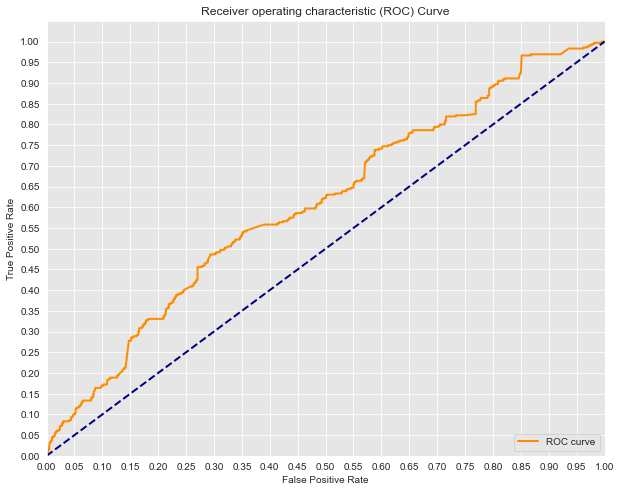

{'rowname': 'pretrain_SVC_metrics',
 'accuracy': 0.6763736263736264,
 'precision': 0.2802303262955854,
 'recall': 0.40555555555555556,
 'roc_auc': 0.6071232876712329}

In [188]:
# Check results - just SVC for the sake of brevity
roc_auc_plot(pretrain_SVC_metrics['fpr'], pretrain_SVC_metrics['tpr'])
{k:v for k,v in pretrain_SVC_metrics.items() if k not in ['fpr', 'tpr']}

In [189]:
# Add to results dataframe
results2 = results.append([pretrain_SVC_metrics, pretrain_NB_metrics, pretrain_RF_metrics], ignore_index=True)
results2

C:\Users\jacks\AppData\Local\Temp\ipykernel_1692\372945393.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results2 = results.append([pretrain_SVC_metrics, pretrain_NB_metrics, pretrain_RF_metrics], ignore_index=True)


,rowname,accuracy,precision,recall,roc_auc,fpr,tpr
0,Novelmethod_SVC_metrics,0.522527,0.257388,0.750000,0.663935,"[0.0, 0.0006849315068493151, 0.001369863013698...","[0.0, 0.0, 0.0, 0.002777777777777778, 0.002777..."
1,Novelmethod_NB_metrics,0.471429,0.253279,0.858333,0.693465,"[0.0, 0.0006849315068493151, 0.000684931506849...","[0.0, 0.0, 0.002777777777777778, 0.00277777777..."
2,Novelmethod_RF_metrics,0.474725,0.253311,0.850000,0.671236,"[0.0, 0.0, 0.0006849315068493151, 0.0027397260...","[0.0, 0.002777777777777778, 0.0027777777777777..."
3,pretrain_SVC_metrics,0.676374,0.280230,0.405556,0.607123,"[0.0, 0.0, 0.002054794520547945, 0.00205479452...","[0.0, 0.005555555555555556, 0.0055555555555555..."
4,pretrain_NB_metrics,0.615385,0.257143,0.500000,0.622137,"[0.0, 0.0, 0.0, 0.0013698630136986301, 0.00136...","[0.0, 0.002777777777777778, 0.0111111111111111..."
5,pretrain_RF_metrics,0.703297,0.272727,0.300000,0.625048,"[0.0, 0.0006849315068493151, 0.002054794520547...","[0.0, 0.008333333333333333, 0.0138888888888888..."


In [190]:
# Second alternative method: Pure VADER sentiment assignation on test data
# Will consider 0 as threshold for positive/negative sentiment
# Only need to directly generate y_pred and prob data
y_pred_3 = X_test_raw.apply(vader_sentiment_score, threshold=0)
probs = X_test_raw.apply(vader_sentiment_score, proba=True).to_numpy()

In [191]:
# Need to convert probs to a 2-D numpy array
probs = np.array(probs.tolist())

In [192]:
# Generate metrics outside of function
accuracy = accuracy_score(y_test, y_pred_3)
precision = precision_score(y_test, y_pred_3)
recall = recall_score(y_test, y_pred_3)
roc_auc = roc_auc_score(y_test, probs[:,1])
fpr, tpr, _ = roc_curve(y_test, probs[:,1])

# Place values in list and add to results
VADER_metrics = {
        'rowname':'VADER_metrics', 'accuracy':accuracy, 'precision':precision, 
        'recall':recall, 'roc_auc':roc_auc, 'fpr':fpr, 'tpr':tpr
        }
results3 = results2.append(VADER_metrics, ignore_index=True)
results3

C:\Users\jacks\AppData\Local\Temp\ipykernel_1692\3396457386.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results3 = results2.append(VADER_metrics, ignore_index=True)


,rowname,accuracy,precision,recall,roc_auc,fpr,tpr
0,Novelmethod_SVC_metrics,0.522527,0.257388,0.750000,0.663935,"[0.0, 0.0006849315068493151, 0.001369863013698...","[0.0, 0.0, 0.0, 0.002777777777777778, 0.002777..."
1,Novelmethod_NB_metrics,0.471429,0.253279,0.858333,0.693465,"[0.0, 0.0006849315068493151, 0.000684931506849...","[0.0, 0.0, 0.002777777777777778, 0.00277777777..."
2,Novelmethod_RF_metrics,0.474725,0.253311,0.850000,0.671236,"[0.0, 0.0, 0.0006849315068493151, 0.0027397260...","[0.0, 0.002777777777777778, 0.0027777777777777..."
3,pretrain_SVC_metrics,0.676374,0.280230,0.405556,0.607123,"[0.0, 0.0, 0.002054794520547945, 0.00205479452...","[0.0, 0.005555555555555556, 0.0055555555555555..."
4,pretrain_NB_metrics,0.615385,0.257143,0.500000,0.622137,"[0.0, 0.0, 0.0, 0.0013698630136986301, 0.00136...","[0.0, 0.002777777777777778, 0.0111111111111111..."
5,pretrain_RF_metrics,0.703297,0.272727,0.300000,0.625048,"[0.0, 0.0006849315068493151, 0.002054794520547...","[0.0, 0.008333333333333333, 0.0138888888888888..."
6,VADER_metrics,0.425275,0.230769,0.816667,0.621724,"[0.0, 0.2541095890410959, 0.2554794520547945, ...","[0.0, 0.45555555555555555, 0.45555555555555555..."


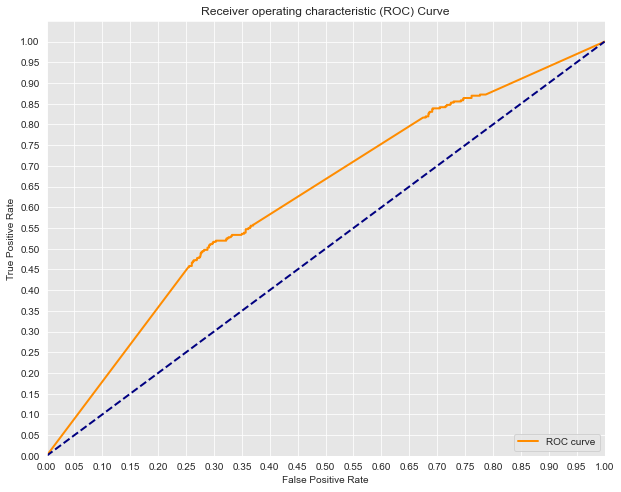

{'rowname': 'VADER_metrics',
 'accuracy': 0.42527472527472526,
 'precision': 0.23076923076923078,
 'recall': 0.8166666666666667,
 'roc_auc': 0.6217237442922374}

In [193]:
# Check results - VADER
roc_auc_plot(VADER_metrics['fpr'], VADER_metrics['tpr'])
{k:v for k,v in VADER_metrics.items() if k not in ['fpr', 'tpr']}

<AxesSubplot:title={'center':'Comparison of accuracy scores'}, xlabel='Model', ylabel='Metric Score'>

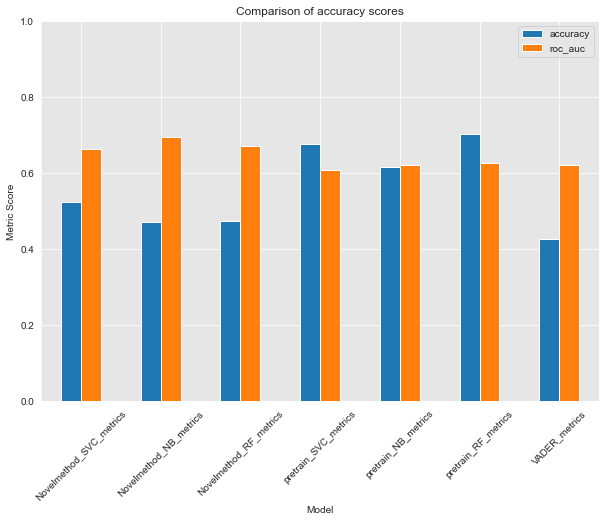

In [219]:
# Plot results in a bar graph

results3.plot.bar(
    'rowname', ['accuracy', 'roc_auc'], 
    title='Comparison of accuracy scores',
    xlabel='Model',
    ylabel='Metric Score',
    ylim=(0, 1),
    rot=45,
    figsize=(10,7)
    )

## Final Discussion
So we can see from a comparison between the three training methods, that while the hashtag method outperforms pure VADER sentiment scoring, it underperforms a simple model trained on non-contextual pre-labelled data. This suggests that, while the novel method brought up by the original paper works intuitively, it simply does not perform as well when pitted against the simple effectiveness of mapping general negative/positive sentiment from a larger database, even one from a different context (product reviews instead of tweets).
<br><br>
Furthermore, the outperformance vs simple VADER sentiment assignation may be due simply to the use of greater sentiment score thresholds for ensuring positive/negative sentiment in training data, with a machine learning model trained on it - more investigation should be done in this direction at a later date.